In [1]:
import os
import os.path
import numpy as np
import logging
import argparse
import pycuda.driver as cuda
import matplotlib.pyplot as plt

import torch
import torchvision

from torch.utils.tensorboard import SummaryWriter

import global_v as glv
from network_parser import parse
from datasets import load_dataset_snn, load_dataset_snn2, load_dataset_snn3
from utils import aboutCudaDevices
from utils import AverageMeter
from utils import CountMulAddSNN, CountMulAddANN
import fsvae_models.fsvae as fsvae
import ann_models.ann_vae as ann_vae
from fsvae_models.snn_layers import LIFSpike
import metrics.inception_score as inception_score
import metrics.clean_fid as clean_fid
import metrics.autoencoder_fid as autoencoder_fid

from tqdm.notebook import trange
from ann_models import *


max_accuracy = 0
min_loss = 1000


In [9]:
def add_hook(net):
    if glv.network_config['spiking']:
        count_mul_add = CountMulAddSNN()
        hook_handles = []
        for m in net.modules():
            if isinstance(m, torch.nn.Conv3d) or isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.ConvTranspose3d) or isinstance(m, LIFSpike):
                handle = m.register_forward_hook(count_mul_add)
                hook_handles.append(handle)
    else:
        count_mul_add = CountMulAddANN()
        hook_handles = []
        for m in net.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.ConvTranspose2d):
                handle = m.register_forward_hook(count_mul_add)
                hook_handles.append(handle)

    return count_mul_add, hook_handles



def write_weight_hist(net, index):
    for n, m in net.named_parameters():
        root, name = os.path.splitext(n)
        writer.add_histogram(root + '/' + name, m, index)

def train(network, trainloader, opti, epoch):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']
    
    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()


    network = network.train()
    
    for batch_idx, (real_img, targets) in enumerate(trainloader):  
        opti.zero_grad()
        real_img = real_img.to(init_device, non_blocking=True)
        targets = targets.to(init_device, non_blocking=True)


        if network_config['loss_func'] == 'mmd':
            # direct spike input
            spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
            x_recon, q_z, p_z, sampled_z = network(spike_input, scheduled=network_config['scheduled']) # sampled_z(B,C,1,1,T)
            losses = network.loss_function_mmd(targets, x_recon, q_z, p_z)
            #losses = network.loss_function_mmd(real_img, x_recon, q_z, p_z)
        elif network_config['loss_func'] == 'kld':
            x_recon, q_z, p_z = network(real_img)
            losses = network.loss_function_kld(x_recon, targets, q_z, p_z)
        else:
            raise ValueError('unrecognized loss function')
        
        losses['loss'].backward()
        
        opti.step()

        loss_meter.update(losses['loss'].detach().cpu().item())
        recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
        dist_meter.update(losses['Distance_Loss'].detach().cpu().item())


        print(f'Train[{epoch}/{max_epoch}] [{batch_idx}/{len(trainloader)}] Loss: {loss_meter.avg}, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

        if batch_idx == len(trainloader)-1:
            os.makedirs(f'checkpoint/{args.name}/imgs/train/', exist_ok=True)
            torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/train/epoch{epoch}_input.png')
            torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/train/epoch{epoch}_recons.png')


    logging.info(f"Train [{epoch}] Loss: {loss_meter.avg} ReconsLoss: {recons_meter.avg} DISTANCE: {dist_meter.avg}")

    

    #writer.add_image('Train/mean_sampled_z', mean_sampled_z.unsqueeze(0), epoch)

    return loss_meter.avg


def test(network, testloader, epoch):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']

    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()

    count_mul_add, hook_handles = add_hook(net)

    network = network.eval()
    with torch.no_grad():
        for batch_idx, (real_img, targets) in enumerate(testloader):   
            real_img = real_img.to(init_device, non_blocking=True)
            targets = targets.to(init_device, non_blocking=True)

            if network_config['loss_func'] == 'mmd':
                # direct spike input
                spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
                x_recon, q_z, p_z, sampled_z = network(spike_input, scheduled=network_config['scheduled'])
                losses = network.loss_function_mmd(targets, x_recon, q_z, p_z)
                #losses = network.loss_function_mmd(real_img, x_recon, q_z, p_z)
                print(f'Test/mul [{epoch}]: {count_mul_add.mul_sum.item() / len(testloader)}')
                print(f'Test/add [{epoch}]: {count_mul_add.add_sum.item() / len(testloader)}')
            elif network_config['loss_func'] == 'kld':
                x_recon, q_z, p_z = network(real_img)
                losses = network.loss_function_kld(targets, x_recon, q_z, p_z)
                print(f'Test/mul [{epoch}]: {count_mul_add.mul_sum / len(testloader)}')
                print(f'Test/add [{epoch}]: {count_mul_add.add_sum / len(testloader)}')
            else:
                raise ValueError('unrecognized loss function')

            loss_meter.update(losses['loss'].detach().cpu().item())
            recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
            dist_meter.update(losses['Distance_Loss'].detach().cpu().item())

            print(f'Test[{epoch}/{max_epoch}] [{batch_idx}/{len(testloader)}] Loss: {loss_meter.avg}, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

            if batch_idx == len(testloader)-1:
                os.makedirs(f'checkpoint/{args.name}/imgs/test/', exist_ok=True)
                torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/test/epoch{epoch}_input.png')
                torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/test/epoch{epoch}_recons.png')

    logging.info(f"Test [{epoch}] Loss: {loss_meter.avg} ReconsLoss: {recons_meter.avg} DISTANCE: {dist_meter.avg}")
    
    for handle in hook_handles:
        handle.remove()

    return loss_meter.avg
        

def plot(network, testloader, index):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']

    count_mul_add, hook_handles = add_hook(net)

    network = network.eval()
    with torch.no_grad():
        for batch_idx, (real_img, targets) in enumerate(testloader):   
            if batch_idx == index:
                
                real_img = real_img.to(init_device, non_blocking=True)
                targets = targets.to(init_device, non_blocking=True)
                if glv.network_config['spiking']:
                    # direct spike input
                    spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
                    x_recon, q_z, p_z, sampled_z = network(spike_input, scheduled=network_config['scheduled']) # sampled_z(B,C,1,1,T)
                else:
                    # direct input
                    x_recon, mu, logvar = network(real_img)
                
                
                os.makedirs(f'checkpoint/{args.name}/imgs/test/', exist_ok=True)
                torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/test/input.png')
                torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/test/recons.png')
                
                real_img = np.transpose(real_img.cpu().numpy(), (0,2,3,1))
                # reshape x_recon to use matplotlib
                x_recon = np.transpose(x_recon.cpu().numpy(), (0, 2, 3, 1))
                
                real_img = (real_img+1)/2
                x_recon = (x_recon+1)/2
                
                N = 2*x_recon.shape[0]
                if N>4:
                    cols = 4
                    rows = int(np.ceil(N/4))
                else:
                    cols = N
                    rows = 1
                fig, axes = plt.subplots(rows, cols, figsize=(10,20))
                for i, ax in enumerate(axes.flat):
                    if i < N:
                        if i % 2 == 0:
                            ax.imshow(real_img[int(i//2)])
                            ax.axis('off')
                        else:
                            ax.imshow(x_recon[int(i//2)])
                            ax.axis('off')
                    else:
                        ax.axis('off')
                        
                plt.subplots_adjust(wspace=0.1, hspace=0.1)
                plt.show()

                return
    return


In [3]:
class Args:
    def __init__(self, checkpoint=None, config="", device=None, name=""):
        self.checkpoint = checkpoint
        self.config = config
        self.device = device
        self.name = name

snn = 'checkpoint/size32_layer4_latent128_dataset2000_batch16/best.pth'
args = Args(checkpoint=snn, config='NetworkConfigs/ToyCelebA_SNN.yaml', device=None, name='size32_layer4_latent128_dataset2000_batch16')

if args.device is None:
    init_device = torch.device("cuda:0")
else:
    init_device = torch.device(f"cuda:{args.device}")
    
os.makedirs(f'checkpoint/{args.name}', exist_ok=True)
writer = SummaryWriter(log_dir=f'checkpoint/{args.name}/tb')
logging.basicConfig(filename=f'checkpoint/{args.name}/{args.name}.log', level=logging.INFO)
    
logging.info("start parsing settings")
    
params = parse(args.config)
network_config = params['Network']

if network_config.get('out_channels') is None:
    network_config['out_channels'] = network_config['in_channels']
    
logging.info("finish parsing settings")
logging.info(network_config)
print(network_config)
        
# Check whether a GPU is available
if torch.cuda.is_available():
    cuda.init()
    c_device = aboutCudaDevices()
    print(c_device.info())
    print("selected device: ", args.device)
else:
    raise Exception("only support gpu")
    
glv.init(network_config, [args.device])

dataset_name = glv.network_config['dataset']

logging.info("dataset loading...")

if dataset_name == "ToyCelebA":
    input_data_path = glv.network_config['input_data_path']
    output_data_path = glv.network_config['output_data_path']
    input_data_path = os.path.expanduser(input_data_path)
    output_data_path = os.path.expanduser(output_data_path)
    train_loader, test_loader = load_dataset_snn2.load_toyceleba(input_data_path, output_data_path)
else:
    data_path = glv.network_config['data_path']

    if dataset_name == "MNIST":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_mnist(data_path)
    elif dataset_name == "FashionMNIST":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_fashionmnist(data_path)

    elif dataset_name == "CIFAR10":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_cifar10(data_path)

    elif dataset_name == "CelebA":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_celebA(data_path)

    else:
        raise Exception('Unrecognized dataset name.')
logging.info("dataset loaded")

if network_config['model'] == 'FSVAE':
    net = fsvae.FSVAE()
elif network_config['model'] == 'FSVAE_large':
    net = fsvae.FSVAELarge()
elif network_config['model'] == 'FSVAE_small':
    net = fsvae.FSVAESmall()
elif network_config['model'] == 'FSAE_small':
    net = fsvae.FSAESmall()
elif network_config['model'] == 'VanillaVAE_large':
    net = ann_vae.VanillaVAELarge()
elif network_config['model'] == 'AE':
    net = ann_ae.AE()
elif network_config['model'] == 'AE_large':
    net = ann_ae.AELarge()
else:
    raise Exception('not defined model')

net = net.to(init_device)
    
if args.checkpoint is not None:
    checkpoint_path = args.checkpoint
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)    


{'epochs': 50, 'batch_size': 40, 'n_steps': 8, 'dataset': 'ToyCelebA', 'in_channels': 3, 'out_channels': 3, 'input_data_path': 'C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/img_align_celeba_sketch', 'output_data_path': 'C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/img_align_celeba', 'lr': 0.001, 'latent_dim': 128, 'input_size': 32, 'model': 'FSVAE', 'k': 20, 'scheduled': True, 'loss_func': 'mmd', 'spiking': True}
1 device(s) found:
    1) NVIDIA GeForce GTX 1650 (Id: 0)
          Memory: 4.29 GB

selected device:  None
loading ToyCelebA


In [4]:
# Train loop    

optimi = 'adam'
if optimi == 'adam':
    optimizer = torch.optim.AdamW(net.parameters(), 
                                lr=glv.network_config['lr'], 
                                betas=(0.9, 0.999), 
                                weight_decay=0.001)
elif optimi == 'sgd':
    optimizer = torch.optim.SGD(net.parameters(), 
                                lr=glv.network_config['lr'],
                                momentum = 0.9)
else:
    raise Exception('unidentified optimizer: use adam or sgd')


best_loss = 1e8
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for e in trange(glv.network_config['epochs']):
        
    write_weight_hist(net, e)
    train_loss = train(net, train_loader, optimizer, e)
    test_loss = test(net, test_loader, e)
#    scheduler.step()

    torch.save(net.state_dict(), f'checkpoint/{args.name}/checkpoint.pth')
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(net.state_dict(), f'checkpoint/{args.name}/best.pth')

#    sample(net, e, batch_size=2)
#    calc_inception_score(net, e)
#    calc_autoencoder_frechet_distance(net, e)
#    calc_clean_fid(net, e)
        
writer.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Train[0/50] [0/50] Loss: 0.2124095857143402, RECONS: 0.20794884860515594, DISTANCE: 0.004460741765797138
Train[0/50] [1/50] Loss: 0.21300344169139862, RECONS: 0.2086753025650978, DISTANCE: 0.00432814029045403
Train[0/50] [2/50] Loss: 0.22095349431037903, RECONS: 0.21662196516990662, DISTANCE: 0.00433152789870898
Train[0/50] [3/50] Loss: 0.2166689708828926, RECONS: 0.2123650386929512, DISTANCE: 0.004303929628804326
Train[0/50] [4/50] Loss: 0.21652708649635316, RECONS: 0.21220597326755525, DISTANCE: 0.004321112297475338
Train[0/50] [5/50] Loss: 0.21308343360821405, RECONS: 0.20874890685081482, DISTANCE: 0.004334526136517525
Train[0/50] [6/50] Loss: 0.21252973590578353, RECONS: 0.20819935202598572, DISTANCE: 0.004330383347613471
Train[0/50] [7/50] Loss: 0.21476449631154537, RECONS: 0.21043726056814194, DISTANCE: 0.004327234521042556
Train[0/50] [8/50] Loss: 0.21760478450192344, RECONS: 0.21326535940170288, DISTANCE: 0.004339423548016284
Train[0/50] [9/50] Loss: 0.22057144194841385, RECONS

Train[1/50] [26/50] Loss: 0.2176883507657934, RECONS: 0.21340599600915555, DISTANCE: 0.004282354187496283
Train[1/50] [27/50] Loss: 0.21850385410445078, RECONS: 0.21422069839068822, DISTANCE: 0.004283155397778111
Train[1/50] [28/50] Loss: 0.21761364053035603, RECONS: 0.21333365656178574, DISTANCE: 0.004279983904341172
Train[1/50] [29/50] Loss: 0.21739753286043803, RECONS: 0.21311562607685725, DISTANCE: 0.00428190651970605
Train[1/50] [30/50] Loss: 0.216960804597024, RECONS: 0.21267733362413221, DISTANCE: 0.004283470552294485
Train[1/50] [31/50] Loss: 0.21693575102835894, RECONS: 0.21265061805024743, DISTANCE: 0.00428513259976171
Train[1/50] [32/50] Loss: 0.21660869410543732, RECONS: 0.21232867286060797, DISTANCE: 0.004280020666280479
Train[1/50] [33/50] Loss: 0.2168711419491207, RECONS: 0.2125964971149669, DISTANCE: 0.0042746441493577815
Train[1/50] [34/50] Loss: 0.2167011001280376, RECONS: 0.21241740201200757, DISTANCE: 0.004283697357667344
Train[1/50] [35/50] Loss: 0.2162562906742096

Train[3/50] [1/50] Loss: 0.21128513664007187, RECONS: 0.20684010535478592, DISTANCE: 0.004445026163011789
Train[3/50] [2/50] Loss: 0.21592484414577484, RECONS: 0.2115702579418818, DISTANCE: 0.00435458030551672
Train[3/50] [3/50] Loss: 0.21491561457514763, RECONS: 0.2105889618396759, DISTANCE: 0.004326649708673358
Train[3/50] [4/50] Loss: 0.21619618237018584, RECONS: 0.21185904145240783, DISTANCE: 0.0043371389620006084
Train[3/50] [5/50] Loss: 0.21498672912518182, RECONS: 0.21064122021198273, DISTANCE: 0.004345507516215245
Train[3/50] [6/50] Loss: 0.21458761606897628, RECONS: 0.21026146837643214, DISTANCE: 0.004326145763375929
Train[3/50] [7/50] Loss: 0.2120720762759447, RECONS: 0.20773781277239323, DISTANCE: 0.004334261990152299
Train[3/50] [8/50] Loss: 0.21543528470728132, RECONS: 0.2111055999994278, DISTANCE: 0.004329684138711955
Train[3/50] [9/50] Loss: 0.21350004076957702, RECONS: 0.2091617077589035, DISTANCE: 0.004338331799954176
Train[3/50] [10/50] Loss: 0.21382081644101578, RECO

Train[4/50] [27/50] Loss: 0.21542707032391004, RECONS: 0.2110979280301503, DISTANCE: 0.0043291434080206925
Train[4/50] [28/50] Loss: 0.2159097749611427, RECONS: 0.2115729759479391, DISTANCE: 0.004336800297786449
Train[4/50] [29/50] Loss: 0.21470984915892283, RECONS: 0.21037171731392543, DISTANCE: 0.004338133117804925
Train[4/50] [30/50] Loss: 0.21393718017685798, RECONS: 0.20959382528258907, DISTANCE: 0.004343356351338087
Train[4/50] [31/50] Loss: 0.21358707500621676, RECONS: 0.20924292970448732, DISTANCE: 0.004344146611401811
Train[4/50] [32/50] Loss: 0.21385645505153772, RECONS: 0.2095220179268808, DISTANCE: 0.004334438281754653
Train[4/50] [33/50] Loss: 0.21388252736891017, RECONS: 0.20954239105477052, DISTANCE: 0.0043401373276377424
Train[4/50] [34/50] Loss: 0.21375203132629395, RECONS: 0.20941499088491713, DISTANCE: 0.004337041492440871
Train[4/50] [35/50] Loss: 0.21406495571136475, RECONS: 0.20972283060352007, DISTANCE: 0.004342126233192782
Train[4/50] [36/50] Loss: 0.21395405724

Train[6/50] [2/50] Loss: 0.22041978438695273, RECONS: 0.21594765782356262, DISTANCE: 0.004472125632067521
Train[6/50] [3/50] Loss: 0.21287639811635017, RECONS: 0.20837972313165665, DISTANCE: 0.004496674286201596
Train[6/50] [4/50] Loss: 0.20619280636310577, RECONS: 0.20169120132923127, DISTANCE: 0.004501605033874511
Train[6/50] [5/50] Loss: 0.20805185784896216, RECONS: 0.20354551076889038, DISTANCE: 0.004506347623343269
Train[6/50] [6/50] Loss: 0.2078335838658469, RECONS: 0.20336322912148067, DISTANCE: 0.004470354478274073
Train[6/50] [7/50] Loss: 0.2096586599946022, RECONS: 0.20521522872149944, DISTANCE: 0.004443430108949542
Train[6/50] [8/50] Loss: 0.21117823984887865, RECONS: 0.2067492985063129, DISTANCE: 0.0044289398421016
Train[6/50] [9/50] Loss: 0.20988031178712846, RECONS: 0.20548200607299805, DISTANCE: 0.004398304969072342
Train[6/50] [10/50] Loss: 0.21150883083993738, RECONS: 0.20714180036024613, DISTANCE: 0.004367029590701515
Train[6/50] [11/50] Loss: 0.21263071025411287, REC

Train[7/50] [28/50] Loss: 0.20758060751290158, RECONS: 0.2033278294678392, DISTANCE: 0.004252779578533152
Train[7/50] [29/50] Loss: 0.2074180339773496, RECONS: 0.2031693786382675, DISTANCE: 0.0042486567127828796
Train[7/50] [30/50] Loss: 0.20812444148525114, RECONS: 0.20387387516037112, DISTANCE: 0.004250567789459901
Train[7/50] [31/50] Loss: 0.20815464900806546, RECONS: 0.2039004131220281, DISTANCE: 0.004254237377608661
Train[7/50] [32/50] Loss: 0.2087302515001008, RECONS: 0.20448136149030743, DISTANCE: 0.004248891597275029
Train[7/50] [33/50] Loss: 0.2095835384200601, RECONS: 0.20534192200969248, DISTANCE: 0.004241617992246414
Train[7/50] [34/50] Loss: 0.2099157452583313, RECONS: 0.2056731321981975, DISTANCE: 0.004242614516988397
Train[7/50] [35/50] Loss: 0.2101985373430782, RECONS: 0.2059614405863815, DISTANCE: 0.004237098367108653
Train[7/50] [36/50] Loss: 0.21006522508891853, RECONS: 0.20583257320764903, DISTANCE: 0.004232653536254892
Train[7/50] [37/50] Loss: 0.20954398497154839,

Train[9/50] [3/50] Loss: 0.2077690102159977, RECONS: 0.2035648413002491, DISTANCE: 0.004204170778393745
Train[9/50] [4/50] Loss: 0.20996737778186797, RECONS: 0.2057414561510086, DISTANCE: 0.004225922282785177
Train[9/50] [5/50] Loss: 0.21324097365140915, RECONS: 0.2090293119351069, DISTANCE: 0.0042116631132860976
Train[9/50] [6/50] Loss: 0.2148261091538838, RECONS: 0.2106098404952458, DISTANCE: 0.004216269856052739
Train[9/50] [7/50] Loss: 0.21961927600204945, RECONS: 0.21534335240721703, DISTANCE: 0.004275923653040081
Train[9/50] [8/50] Loss: 0.2216029233402676, RECONS: 0.21732328832149506, DISTANCE: 0.004279635639654266
Train[9/50] [9/50] Loss: 0.21932900547981263, RECONS: 0.21504440158605576, DISTANCE: 0.0042846040334552525
Train[9/50] [10/50] Loss: 0.21869351782582022, RECONS: 0.2144233760508624, DISTANCE: 0.0042701421136205845
Train[9/50] [11/50] Loss: 0.21828141808509827, RECONS: 0.21399488672614098, DISTANCE: 0.004286531320152183
Train[9/50] [12/50] Loss: 0.2191044527750749, REC

Train[10/50] [29/50] Loss: 0.21063043574492138, RECONS: 0.2063641553123792, DISTANCE: 0.004266281488041083
Train[10/50] [30/50] Loss: 0.21016409320216026, RECONS: 0.20590432372785383, DISTANCE: 0.004259770360564993
Train[10/50] [31/50] Loss: 0.20931684179231524, RECONS: 0.20505695277824998, DISTANCE: 0.004259889668901451
Train[10/50] [32/50] Loss: 0.20982263124350345, RECONS: 0.20556242854306192, DISTANCE: 0.004260203518876524
Train[10/50] [33/50] Loss: 0.21012726031682072, RECONS: 0.2058673522928182, DISTANCE: 0.004259908845757737
Train[10/50] [34/50] Loss: 0.21036405733653477, RECONS: 0.20609558735574995, DISTANCE: 0.004268470659319843
Train[10/50] [35/50] Loss: 0.2100762435131603, RECONS: 0.20580905924240747, DISTANCE: 0.0042671849821797675
Train[10/50] [36/50] Loss: 0.20925539047331423, RECONS: 0.20498337898705457, DISTANCE: 0.004272012102946236
Train[10/50] [37/50] Loss: 0.2093910053372383, RECONS: 0.20511421639668315, DISTANCE: 0.0042767894307249475
Train[10/50] [38/50] Loss: 0.2

Train[12/50] [3/50] Loss: 0.20709028095006943, RECONS: 0.20280427858233452, DISTANCE: 0.0042860017856583
Train[12/50] [4/50] Loss: 0.1993911921977997, RECONS: 0.19508347511291504, DISTANCE: 0.0043077155947685245
Train[12/50] [5/50] Loss: 0.19583806147178015, RECONS: 0.19150250653425852, DISTANCE: 0.004335553850978613
Train[12/50] [6/50] Loss: 0.19719736278057098, RECONS: 0.1928787657192775, DISTANCE: 0.004318596129970891
Train[12/50] [7/50] Loss: 0.19379852898418903, RECONS: 0.18950448743999004, DISTANCE: 0.004294039972592145
Train[12/50] [8/50] Loss: 0.19364158478048113, RECONS: 0.1893456992175844, DISTANCE: 0.0042958842693931526
Train[12/50] [9/50] Loss: 0.19140092879533768, RECONS: 0.18712933659553527, DISTANCE: 0.00427159033715725
Train[12/50] [10/50] Loss: 0.19670905714685266, RECONS: 0.19243349541317334, DISTANCE: 0.004275560590692542
Train[12/50] [11/50] Loss: 0.19692496210336685, RECONS: 0.19265115881959596, DISTANCE: 0.004273802391253412
Train[12/50] [12/50] Loss: 0.1989330695

Train[13/50] [28/50] Loss: 0.2071424537691577, RECONS: 0.20277768476256008, DISTANCE: 0.0043647675614418655
Train[13/50] [29/50] Loss: 0.20700787802537282, RECONS: 0.2026498481631279, DISTANCE: 0.004358028620481491
Train[13/50] [30/50] Loss: 0.2072743965733436, RECONS: 0.2029133213143195, DISTANCE: 0.004361073892082899
Train[13/50] [31/50] Loss: 0.20816502859815955, RECONS: 0.2038022931665182, DISTANCE: 0.004362733889138326
Train[13/50] [32/50] Loss: 0.20880546443390124, RECONS: 0.20444962337161554, DISTANCE: 0.004355839495970445
Train[13/50] [33/50] Loss: 0.20785082876682281, RECONS: 0.2034913437331424, DISTANCE: 0.004359483664088389
Train[13/50] [34/50] Loss: 0.20802257444177355, RECONS: 0.2036586046218872, DISTANCE: 0.004363968635776213
Train[13/50] [35/50] Loss: 0.20850601171453795, RECONS: 0.20414121987091172, DISTANCE: 0.004364790886433588
Train[13/50] [36/50] Loss: 0.2082362082358953, RECONS: 0.20387073988850052, DISTANCE: 0.004365467353145013
Train[13/50] [37/50] Loss: 0.208297

Train[15/50] [2/50] Loss: 0.21426750719547272, RECONS: 0.20992877086003622, DISTANCE: 0.0043387349384526415
Train[15/50] [3/50] Loss: 0.20725685730576515, RECONS: 0.2029157057404518, DISTANCE: 0.0043411486549302936
Train[15/50] [4/50] Loss: 0.20609078109264373, RECONS: 0.20174669921398164, DISTANCE: 0.004344080947339535
Train[15/50] [5/50] Loss: 0.21022535612185797, RECONS: 0.2058801700671514, DISTANCE: 0.0043451864427576465
Train[15/50] [6/50] Loss: 0.21545003993170603, RECONS: 0.21113640069961548, DISTANCE: 0.004313639764274869
Train[15/50] [7/50] Loss: 0.21515103429555893, RECONS: 0.21085226349532604, DISTANCE: 0.004298771673347801
Train[15/50] [8/50] Loss: 0.21487431890434688, RECONS: 0.21055571569336784, DISTANCE: 0.004318603573160039
Train[15/50] [9/50] Loss: 0.21443930715322496, RECONS: 0.21011153608560562, DISTANCE: 0.004327770741656423
Train[15/50] [10/50] Loss: 0.21465495093302292, RECONS: 0.21031264689835635, DISTANCE: 0.00434230441566218
Train[15/50] [11/50] Loss: 0.2136102

Train[16/50] [28/50] Loss: 0.21013318516057114, RECONS: 0.20586160904374615, DISTANCE: 0.004271575651163685
Train[16/50] [29/50] Loss: 0.21024731794993082, RECONS: 0.2059802417953809, DISTANCE: 0.004267075487102072
Train[16/50] [30/50] Loss: 0.21104257818191283, RECONS: 0.20676630879602126, DISTANCE: 0.004276268634824983
Train[16/50] [31/50] Loss: 0.21111709298565984, RECONS: 0.2068441235460341, DISTANCE: 0.0042729685083031654
Train[16/50] [32/50] Loss: 0.21087647748715949, RECONS: 0.2065993104920243, DISTANCE: 0.004277166303698764
Train[16/50] [33/50] Loss: 0.21092254624647253, RECONS: 0.20664708141018362, DISTANCE: 0.004275464261060252
Train[16/50] [34/50] Loss: 0.2111906064408166, RECONS: 0.20691253117152622, DISTANCE: 0.004278074750410659
Train[16/50] [35/50] Loss: 0.21133527035514513, RECONS: 0.2070538993510935, DISTANCE: 0.004281370525455309
Train[16/50] [36/50] Loss: 0.21160232094494072, RECONS: 0.2073179350511448, DISTANCE: 0.0042843855665744964
Train[16/50] [37/50] Loss: 0.212

Train[18/50] [2/50] Loss: 0.2161134829123815, RECONS: 0.2118105391661326, DISTANCE: 0.0043029470058778925
Train[18/50] [3/50] Loss: 0.2142367847263813, RECONS: 0.20997203886508942, DISTANCE: 0.004264747723937035
Train[18/50] [4/50] Loss: 0.2175866335630417, RECONS: 0.21328578889369965, DISTANCE: 0.004300845135003328
Train[18/50] [5/50] Loss: 0.21518535415331522, RECONS: 0.21088280777136484, DISTANCE: 0.004302546692391236
Train[18/50] [6/50] Loss: 0.2118485016482217, RECONS: 0.207559768642698, DISTANCE: 0.004288732406816312
Train[18/50] [7/50] Loss: 0.21569061279296875, RECONS: 0.21135611459612846, DISTANCE: 0.00433449714910239
Train[18/50] [8/50] Loss: 0.21843294633759391, RECONS: 0.21410700678825378, DISTANCE: 0.004325939445859856
Train[18/50] [9/50] Loss: 0.21819559931755067, RECONS: 0.21387910544872285, DISTANCE: 0.004316494287922979
Train[18/50] [10/50] Loss: 0.21794789894060654, RECONS: 0.2136295654556968, DISTANCE: 0.004318334331566637
Train[18/50] [11/50] Loss: 0.216992414246002

Train[19/50] [27/50] Loss: 0.21193605342081615, RECONS: 0.20761404931545258, DISTANCE: 0.00432200514478609
Train[19/50] [28/50] Loss: 0.21117703770769053, RECONS: 0.20684705314965085, DISTANCE: 0.004329985786422059
Train[19/50] [29/50] Loss: 0.2111895908912023, RECONS: 0.20686131666104, DISTANCE: 0.004328275293422242
Train[19/50] [30/50] Loss: 0.21152717740305008, RECONS: 0.20719544877929072, DISTANCE: 0.004331729802933912
Train[19/50] [31/50] Loss: 0.21158279431983829, RECONS: 0.20724678365513682, DISTANCE: 0.004336011908890214
Train[19/50] [32/50] Loss: 0.21122241697528146, RECONS: 0.20689206592964404, DISTANCE: 0.004330352068681157
Train[19/50] [33/50] Loss: 0.21187168052967856, RECONS: 0.20753901627133875, DISTANCE: 0.00433266518281444
Train[19/50] [34/50] Loss: 0.21198484216417585, RECONS: 0.20765678329127177, DISTANCE: 0.004328059757660542
Train[19/50] [35/50] Loss: 0.21155042946338654, RECONS: 0.20723160521851647, DISTANCE: 0.0043188251050499575
Train[19/50] [36/50] Loss: 0.2119

Train[21/50] [1/50] Loss: 0.2146242931485176, RECONS: 0.21027810126543045, DISTANCE: 0.0043461923487484455
Train[21/50] [2/50] Loss: 0.21201722820599875, RECONS: 0.2077213724454244, DISTANCE: 0.004295854363590479
Train[21/50] [3/50] Loss: 0.2116176225244999, RECONS: 0.20725971087813377, DISTANCE: 0.004357909900136292
Train[21/50] [4/50] Loss: 0.20827116966247558, RECONS: 0.203950497508049, DISTANCE: 0.004320671781897545
Train[21/50] [5/50] Loss: 0.2057856172323227, RECONS: 0.2015089193979899, DISTANCE: 0.0042766981447736425
Train[21/50] [6/50] Loss: 0.2085606242929186, RECONS: 0.20427556335926056, DISTANCE: 0.004285060667565891
Train[21/50] [7/50] Loss: 0.2079920507967472, RECONS: 0.20368103682994843, DISTANCE: 0.004311013501137495
Train[21/50] [8/50] Loss: 0.20752999848789638, RECONS: 0.20321340362230936, DISTANCE: 0.00431659414122502
Train[21/50] [9/50] Loss: 0.20933383852243423, RECONS: 0.2050211325287819, DISTANCE: 0.004312705434858799
Train[21/50] [10/50] Loss: 0.2071103114973415,

Train[22/50] [27/50] Loss: 0.20506623121244566, RECONS: 0.20072748618466513, DISTANCE: 0.004338745659749422
Train[22/50] [28/50] Loss: 0.20714387143480367, RECONS: 0.2028120951405887, DISTANCE: 0.0043317771613084035
Train[22/50] [29/50] Loss: 0.20815151582161587, RECONS: 0.20382409443457922, DISTANCE: 0.004327422364925345
Train[22/50] [30/50] Loss: 0.20915253123929423, RECONS: 0.20482425776220137, DISTANCE: 0.004328274453479436
Train[22/50] [31/50] Loss: 0.20904326299205422, RECONS: 0.2047211085446179, DISTANCE: 0.0043221555824857205
Train[22/50] [32/50] Loss: 0.20872987987417163, RECONS: 0.20440857202717752, DISTANCE: 0.004321309088757544
Train[22/50] [33/50] Loss: 0.20946534766870387, RECONS: 0.20514628554091735, DISTANCE: 0.004319063442594865
Train[22/50] [34/50] Loss: 0.20916136460644857, RECONS: 0.2048511688198362, DISTANCE: 0.00431019715698702
Train[22/50] [35/50] Loss: 0.21002801756064096, RECONS: 0.20570905092689726, DISTANCE: 0.0043189679531173576
Train[22/50] [36/50] Loss: 0.

Train[24/50] [1/50] Loss: 0.19660311192274094, RECONS: 0.1922784298658371, DISTANCE: 0.004324682289734483
Train[24/50] [2/50] Loss: 0.1996018389860789, RECONS: 0.19534563521544138, DISTANCE: 0.004256203770637512
Train[24/50] [3/50] Loss: 0.20923474803566933, RECONS: 0.20496511086821556, DISTANCE: 0.00426963553763926
Train[24/50] [4/50] Loss: 0.20717243254184722, RECONS: 0.20289551317691804, DISTANCE: 0.004276917222887278
Train[24/50] [5/50] Loss: 0.20688802500565848, RECONS: 0.20262890060742697, DISTANCE: 0.004259122147535284
Train[24/50] [6/50] Loss: 0.20803613109248026, RECONS: 0.2037646004131862, DISTANCE: 0.0042715296149253845
Train[24/50] [7/50] Loss: 0.20754805207252502, RECONS: 0.2032534871250391, DISTANCE: 0.004294563899748027
Train[24/50] [8/50] Loss: 0.20786964893341064, RECONS: 0.20354896121554905, DISTANCE: 0.004320687096979883
Train[24/50] [9/50] Loss: 0.21042185723781587, RECONS: 0.20612798929214476, DISTANCE: 0.004293867526575923
Train[24/50] [10/50] Loss: 0.208337351679

Train[25/50] [26/50] Loss: 0.20551816125710806, RECONS: 0.20117573936780295, DISTANCE: 0.004342421596110971
Train[25/50] [27/50] Loss: 0.20696195268205234, RECONS: 0.2026246003806591, DISTANCE: 0.0043373518191011885
Train[25/50] [28/50] Loss: 0.20737213204646932, RECONS: 0.2030364172212009, DISTANCE: 0.004335714359607162
Train[25/50] [29/50] Loss: 0.20876419295867285, RECONS: 0.2044212390979131, DISTANCE: 0.004342953317488233
Train[25/50] [30/50] Loss: 0.20917979892223112, RECONS: 0.2048374472125884, DISTANCE: 0.004342351198917435
Train[25/50] [31/50] Loss: 0.2090065274387598, RECONS: 0.20467141270637512, DISTANCE: 0.004335114033892751
Train[25/50] [32/50] Loss: 0.2086381713549296, RECONS: 0.20430832423947073, DISTANCE: 0.0043298462546910305
Train[25/50] [33/50] Loss: 0.20901519454577389, RECONS: 0.20468834305510802, DISTANCE: 0.004326850682606592
Train[25/50] [34/50] Loss: 0.2094962899174009, RECONS: 0.20517220199108124, DISTANCE: 0.004324087207870824
Train[25/50] [35/50] Loss: 0.2099

Train[27/50] [0/50] Loss: 0.22690826654434204, RECONS: 0.22275157272815704, DISTANCE: 0.0041566952131688595
Train[27/50] [1/50] Loss: 0.20914170891046524, RECONS: 0.20492997765541077, DISTANCE: 0.004211731255054474
Train[27/50] [2/50] Loss: 0.20463363826274872, RECONS: 0.20041599869728088, DISTANCE: 0.004217638323704402
Train[27/50] [3/50] Loss: 0.2029118426144123, RECONS: 0.1985924169421196, DISTANCE: 0.0043194228783249855
Train[27/50] [4/50] Loss: 0.20096617937088013, RECONS: 0.1966497391462326, DISTANCE: 0.004316439013928175
Train[27/50] [5/50] Loss: 0.20064547657966614, RECONS: 0.19631338119506836, DISTANCE: 0.00433209507415692
Train[27/50] [6/50] Loss: 0.20150119491985866, RECONS: 0.19715913491589682, DISTANCE: 0.0043420604696231225
Train[27/50] [7/50] Loss: 0.20303312130272388, RECONS: 0.19869419373571873, DISTANCE: 0.004338928323704749
Train[27/50] [8/50] Loss: 0.2025013400448693, RECONS: 0.1981418099668291, DISTANCE: 0.004359530595441659
Train[27/50] [9/50] Loss: 0.204484823346

Train[28/50] [25/50] Loss: 0.20974523000992262, RECONS: 0.20543958590580866, DISTANCE: 0.004305643871283302
Train[28/50] [26/50] Loss: 0.2103797180785073, RECONS: 0.20606562550421115, DISTANCE: 0.004314092608789603
Train[28/50] [27/50] Loss: 0.2106465244931834, RECONS: 0.20633244248373167, DISTANCE: 0.0043140822755438945
Train[28/50] [28/50] Loss: 0.21093504028073673, RECONS: 0.20661253096728488, DISTANCE: 0.004322509698826691
Train[28/50] [29/50] Loss: 0.21087812632322311, RECONS: 0.20656633824110032, DISTANCE: 0.004311788252865275
Train[28/50] [30/50] Loss: 0.2114112026268436, RECONS: 0.2070985412405383, DISTANCE: 0.0043126613562626225
Train[28/50] [31/50] Loss: 0.2111223302781582, RECONS: 0.20680535212159157, DISTANCE: 0.004316978112910874
Train[28/50] [32/50] Loss: 0.21105257986169873, RECONS: 0.2067371972582557, DISTANCE: 0.004315382420000705
Train[28/50] [33/50] Loss: 0.2110336440451005, RECONS: 0.20671407966052785, DISTANCE: 0.004319564042174641
Train[28/50] [34/50] Loss: 0.2107

Test/mul [29]: 27326756.0
Test/add [29]: 810518592.0
Test[29/50] [0/1] Loss: 1.2068198919296265, RECONS: 1.2022367715835571, DISTANCE: 0.0045830849558115005
Train[30/50] [0/50] Loss: 0.21056804060935974, RECONS: 0.20614321529865265, DISTANCE: 0.004424832761287689
Train[30/50] [1/50] Loss: 0.20213447511196136, RECONS: 0.19779646396636963, DISTANCE: 0.004338018363341689
Train[30/50] [2/50] Loss: 0.20267734924952188, RECONS: 0.19824965794881186, DISTANCE: 0.0044276971990863485
Train[30/50] [3/50] Loss: 0.20761213451623917, RECONS: 0.20327359065413475, DISTANCE: 0.004338547005318105
Train[30/50] [4/50] Loss: 0.20971913933753966, RECONS: 0.20541337132453918, DISTANCE: 0.004305770900100469
Train[30/50] [5/50] Loss: 0.20771709084510803, RECONS: 0.20339704304933548, DISTANCE: 0.004320051210621993
Train[30/50] [6/50] Loss: 0.20590209535190038, RECONS: 0.20156070590019226, DISTANCE: 0.004341391314353261
Train[30/50] [7/50] Loss: 0.2069099172949791, RECONS: 0.20255892723798752, DISTANCE: 0.004350

Train[31/50] [24/50] Loss: 0.2068651008605957, RECONS: 0.20258994162082672, DISTANCE: 0.004275157880038023
Train[31/50] [25/50] Loss: 0.20679859874340203, RECONS: 0.20252861025241706, DISTANCE: 0.004269987094001128
Train[31/50] [26/50] Loss: 0.20677944576298748, RECONS: 0.20250897164698, DISTANCE: 0.004270472805257197
Train[31/50] [27/50] Loss: 0.2070731126836368, RECONS: 0.20280467399529048, DISTANCE: 0.0042684373911470175
Train[31/50] [28/50] Loss: 0.20657994983525113, RECONS: 0.20230721399701876, DISTANCE: 0.004272734489420365
Train[31/50] [29/50] Loss: 0.2066801811257998, RECONS: 0.20240290462970734, DISTANCE: 0.0042772751301527025
Train[31/50] [30/50] Loss: 0.20715795841909224, RECONS: 0.20287422835826874, DISTANCE: 0.004283728844095622
Train[31/50] [31/50] Loss: 0.207571383100003, RECONS: 0.20329253375530243, DISTANCE: 0.004278847991372459
Train[31/50] [32/50] Loss: 0.2077699335235538, RECONS: 0.20348455102154703, DISTANCE: 0.004285381373130914
Train[31/50] [33/50] Loss: 0.207922

Train[32/50] [49/50] Loss: 0.21073412269353867, RECONS: 0.2063629850745201, DISTANCE: 0.004371137637645006
Test/mul [32]: 27308244.0
Test/add [32]: 836923392.0
Test[32/50] [0/1] Loss: 1.275437355041504, RECONS: 1.2711031436920166, DISTANCE: 0.004334260243922472
Train[33/50] [0/50] Loss: 0.2190735787153244, RECONS: 0.2145162671804428, DISTANCE: 0.004557305481284857
Train[33/50] [1/50] Loss: 0.21476123481988907, RECONS: 0.21024268865585327, DISTANCE: 0.00451854127459228
Train[33/50] [2/50] Loss: 0.22484602530797324, RECONS: 0.2202915052572886, DISTANCE: 0.0045545158597330255
Train[33/50] [3/50] Loss: 0.22032399848103523, RECONS: 0.21580924466252327, DISTANCE: 0.004514749743975699
Train[33/50] [4/50] Loss: 0.21768485009670258, RECONS: 0.21317536532878875, DISTANCE: 0.004509482439607382
Train[33/50] [5/50] Loss: 0.21600490560134253, RECONS: 0.21154246479272842, DISTANCE: 0.004462439722071092
Train[33/50] [6/50] Loss: 0.2123655868428094, RECONS: 0.2078746450798852, DISTANCE: 0.0044909402994

Train[34/50] [23/50] Loss: 0.21033854658404985, RECONS: 0.2059970454623302, DISTANCE: 0.00434150251870354
Train[34/50] [24/50] Loss: 0.21198697328567506, RECONS: 0.20765119194984435, DISTANCE: 0.0043357832357287405
Train[34/50] [25/50] Loss: 0.21141548512073663, RECONS: 0.2070661450807865, DISTANCE: 0.004349341795135003
Train[34/50] [26/50] Loss: 0.2114352434873581, RECONS: 0.2070949066568304, DISTANCE: 0.0043403382964984135
Train[34/50] [27/50] Loss: 0.20942734128662518, RECONS: 0.2050835538123335, DISTANCE: 0.004343788804752486
Train[34/50] [28/50] Loss: 0.20897107853971678, RECONS: 0.20462549965957116, DISTANCE: 0.004345580068384779
Train[34/50] [29/50] Loss: 0.20882929513851803, RECONS: 0.20448241184155147, DISTANCE: 0.0043468846163402
Train[34/50] [30/50] Loss: 0.20860810385596368, RECONS: 0.20426334825254255, DISTANCE: 0.004344756760063672
Train[34/50] [31/50] Loss: 0.20850849244743586, RECONS: 0.2041618120856583, DISTANCE: 0.0043466813513077796
Train[34/50] [32/50] Loss: 0.20795

Train[35/50] [49/50] Loss: 0.21132022380828858, RECONS: 0.20697251468896866, DISTANCE: 0.004347710041329265
Test/mul [35]: 27309296.0
Test/add [35]: 822106304.0
Test[35/50] [0/1] Loss: 1.249110221862793, RECONS: 1.2447624206542969, DISTANCE: 0.004347783513367176
Train[36/50] [0/50] Loss: 0.18765994906425476, RECONS: 0.1833145171403885, DISTANCE: 0.004345437977463007
Train[36/50] [1/50] Loss: 0.19916752725839615, RECONS: 0.19482648372650146, DISTANCE: 0.004341045394539833
Train[36/50] [2/50] Loss: 0.2034444510936737, RECONS: 0.19909712175528207, DISTANCE: 0.004347328872730334
Train[36/50] [3/50] Loss: 0.19732602313160896, RECONS: 0.1929601915180683, DISTANCE: 0.0043658302165567875
Train[36/50] [4/50] Loss: 0.20012886822223663, RECONS: 0.19576296210289001, DISTANCE: 0.0043659060262143615
Train[36/50] [5/50] Loss: 0.19830607871214548, RECONS: 0.19397671769062677, DISTANCE: 0.004329360478247206
Train[36/50] [6/50] Loss: 0.19805662759712764, RECONS: 0.19373048629079545, DISTANCE: 0.00432614

Train[37/50] [23/50] Loss: 0.2031177623818318, RECONS: 0.1987809638182322, DISTANCE: 0.004336798641209801
Train[37/50] [24/50] Loss: 0.20284393131732942, RECONS: 0.19851010382175446, DISTANCE: 0.004333827849477529
Train[37/50] [25/50] Loss: 0.2039812207221985, RECONS: 0.19964830863934296, DISTANCE: 0.004332912512696707
Train[37/50] [26/50] Loss: 0.20474722263989625, RECONS: 0.2004145703933857, DISTANCE: 0.004332652919132401
Train[37/50] [27/50] Loss: 0.2042131567639964, RECONS: 0.1998776969100748, DISTANCE: 0.004335460751982672
Train[37/50] [28/50] Loss: 0.20475462952564502, RECONS: 0.20041122364586797, DISTANCE: 0.004343406730813199
Train[37/50] [29/50] Loss: 0.20508923381567, RECONS: 0.20074974646170934, DISTANCE: 0.0043394882697612045
Train[37/50] [30/50] Loss: 0.20498314740196352, RECONS: 0.2006445094462364, DISTANCE: 0.004338638766879036
Train[37/50] [31/50] Loss: 0.20429158583283424, RECONS: 0.19995594630017877, DISTANCE: 0.004335640143835917
Train[37/50] [32/50] Loss: 0.20430629

Train[38/50] [49/50] Loss: 0.20743766754865647, RECONS: 0.20308149367570877, DISTANCE: 0.004356174441054464
Test/mul [38]: 27334000.0
Test/add [38]: 817592384.0
Test[38/50] [0/1] Loss: 1.2313498258590698, RECONS: 1.227020263671875, DISTANCE: 0.004329572431743145
Train[39/50] [0/50] Loss: 0.2095404416322708, RECONS: 0.20539043843746185, DISTANCE: 0.004150004591792822
Train[39/50] [1/50] Loss: 0.2121444270014763, RECONS: 0.2079058662056923, DISTANCE: 0.004238558234646916
Train[39/50] [2/50] Loss: 0.21666334569454193, RECONS: 0.21245005230108896, DISTANCE: 0.004213289202501376
Train[39/50] [3/50] Loss: 0.21408956497907639, RECONS: 0.20981958508491516, DISTANCE: 0.00426997581962496
Train[39/50] [4/50] Loss: 0.2131453961133957, RECONS: 0.20883773565292357, DISTANCE: 0.004307656642049551
Train[39/50] [5/50] Loss: 0.21199953307708105, RECONS: 0.20768838624159494, DISTANCE: 0.004311142799754937
Train[39/50] [6/50] Loss: 0.2083876473563058, RECONS: 0.20406522069658553, DISTANCE: 0.0043224236661

Train[40/50] [23/50] Loss: 0.21071852557361126, RECONS: 0.20628104669352373, DISTANCE: 0.0044374784726339085
Train[40/50] [24/50] Loss: 0.21077288806438446, RECONS: 0.20634159207344055, DISTANCE: 0.004431295488029718
Train[40/50] [25/50] Loss: 0.21119694755627558, RECONS: 0.2067814412025305, DISTANCE: 0.004415505637343113
Train[40/50] [26/50] Loss: 0.2113260339807581, RECONS: 0.20691899182619872, DISTANCE: 0.004407041585417809
Train[40/50] [27/50] Loss: 0.21177135833672114, RECONS: 0.20736545590417726, DISTANCE: 0.004405902000144124
Train[40/50] [28/50] Loss: 0.21209437477177587, RECONS: 0.2076837476985208, DISTANCE: 0.004410626559421934
Train[40/50] [29/50] Loss: 0.21247622569402058, RECONS: 0.20806622157494228, DISTANCE: 0.004410003777593374
Train[40/50] [30/50] Loss: 0.21185157375950966, RECONS: 0.20744247253864043, DISTANCE: 0.004409101010570603
Train[40/50] [31/50] Loss: 0.21229975577443838, RECONS: 0.20789363933727145, DISTANCE: 0.004406116102472879
Train[40/50] [32/50] Loss: 0.2

Train[41/50] [48/50] Loss: 0.20573155186614211, RECONS: 0.2013468386567369, DISTANCE: 0.004384713142882197
Train[41/50] [49/50] Loss: 0.20614776581525804, RECONS: 0.20176280796527862, DISTANCE: 0.004384957747533918
Test/mul [41]: 27270136.0
Test/add [41]: 833853504.0
Test[41/50] [0/1] Loss: 1.2667046785354614, RECONS: 1.2620006799697876, DISTANCE: 0.004703993909060955
Train[42/50] [0/50] Loss: 0.19968700408935547, RECONS: 0.19513829052448273, DISTANCE: 0.004548707976937294
Train[42/50] [1/50] Loss: 0.20085319131612778, RECONS: 0.19634992629289627, DISTANCE: 0.004503261297941208
Train[42/50] [2/50] Loss: 0.19519522786140442, RECONS: 0.1905886928240458, DISTANCE: 0.004606530846407016
Train[42/50] [3/50] Loss: 0.1978580802679062, RECONS: 0.19323888421058655, DISTANCE: 0.004619194194674492
Train[42/50] [4/50] Loss: 0.20147220492362977, RECONS: 0.196883362531662, DISTANCE: 0.004588840901851654
Train[42/50] [5/50] Loss: 0.19937531650066376, RECONS: 0.19481774667898813, DISTANCE: 0.0045575691

Train[43/50] [22/50] Loss: 0.20247164692567743, RECONS: 0.19809813667898593, DISTANCE: 0.004373510712352784
Train[43/50] [23/50] Loss: 0.202692453439037, RECONS: 0.19832653924822807, DISTANCE: 0.004365914481847237
Train[43/50] [24/50] Loss: 0.2027154368162155, RECONS: 0.19835420072078705, DISTANCE: 0.0043612362071871755
Train[43/50] [25/50] Loss: 0.20271625140538582, RECONS: 0.19836002588272095, DISTANCE: 0.004356225862955818
Train[43/50] [26/50] Loss: 0.2030070341295666, RECONS: 0.198653315504392, DISTANCE: 0.00435371898735563
Train[43/50] [27/50] Loss: 0.204474609877382, RECONS: 0.20011271110602788, DISTANCE: 0.0043618991039693356
Train[43/50] [28/50] Loss: 0.20436227424391384, RECONS: 0.2000043916291204, DISTANCE: 0.004357882855652735
Train[43/50] [29/50] Loss: 0.2047675500313441, RECONS: 0.20040560563405355, DISTANCE: 0.004361944800863663
Train[43/50] [30/50] Loss: 0.20457461908940347, RECONS: 0.20020871056664374, DISTANCE: 0.004365909123612988
Train[43/50] [31/50] Loss: 0.20443711

Train[44/50] [47/50] Loss: 0.20608577722062668, RECONS: 0.20166428231944641, DISTANCE: 0.0044214945325317485
Train[44/50] [48/50] Loss: 0.20646426993973402, RECONS: 0.20204238471936206, DISTANCE: 0.004421884925769908
Train[44/50] [49/50] Loss: 0.2063288202881813, RECONS: 0.2019046026468277, DISTANCE: 0.004424217222258449
Test/mul [44]: 27316952.0
Test/add [44]: 838631040.0
Test[44/50] [0/1] Loss: 1.074979305267334, RECONS: 1.0703914165496826, DISTANCE: 0.004587838891893625
Train[45/50] [0/50] Loss: 0.2040959894657135, RECONS: 0.19969752430915833, DISTANCE: 0.004398459102958441
Train[45/50] [1/50] Loss: 0.20353736728429794, RECONS: 0.1989559531211853, DISTANCE: 0.004581408575177193
Train[45/50] [2/50] Loss: 0.20552041629950205, RECONS: 0.20109841724236807, DISTANCE: 0.0044219948661824065
Train[45/50] [3/50] Loss: 0.2131061963737011, RECONS: 0.20868446305394173, DISTANCE: 0.00442173017654568
Train[45/50] [4/50] Loss: 0.20630074441432952, RECONS: 0.20190505385398866, DISTANCE: 0.004395688

Train[46/50] [21/50] Loss: 0.20895568078214471, RECONS: 0.20451549643819983, DISTANCE: 0.004440184174613519
Train[46/50] [22/50] Loss: 0.21001584892687591, RECONS: 0.20558525103589761, DISTANCE: 0.0044305979517167025
Train[46/50] [23/50] Loss: 0.20933731893698374, RECONS: 0.20490240616103014, DISTANCE: 0.004434913086394469
Train[46/50] [24/50] Loss: 0.20901136934757233, RECONS: 0.20456668198108674, DISTANCE: 0.004444687813520432
Train[46/50] [25/50] Loss: 0.209467578965884, RECONS: 0.20502728395737135, DISTANCE: 0.004440295295073436
Train[46/50] [26/50] Loss: 0.20856955316331652, RECONS: 0.20412940173237412, DISTANCE: 0.004440151793123396
Train[46/50] [27/50] Loss: 0.21011848534856523, RECONS: 0.20567890788827622, DISTANCE: 0.004439578241934734
Train[46/50] [28/50] Loss: 0.20966519261228628, RECONS: 0.20521758188461436, DISTANCE: 0.004447611723223637
Train[46/50] [29/50] Loss: 0.21020445823669434, RECONS: 0.20575903008381527, DISTANCE: 0.004445429270466168
Train[46/50] [30/50] Loss: 0.

Train[47/50] [46/50] Loss: 0.20509407811976493, RECONS: 0.2006394679241992, DISTANCE: 0.004454610255011853
Train[47/50] [47/50] Loss: 0.20497302835186323, RECONS: 0.2005165840188662, DISTANCE: 0.004456444371802111
Train[47/50] [48/50] Loss: 0.20491773771996402, RECONS: 0.20046651485014935, DISTANCE: 0.004451222974350866
Train[47/50] [49/50] Loss: 0.205012224316597, RECONS: 0.20056430518627166, DISTANCE: 0.004447919223457575
Test/mul [47]: 27330732.0
Test/add [47]: 825760000.0
Test[47/50] [0/1] Loss: 1.1835522651672363, RECONS: 1.179184079170227, DISTANCE: 0.004368239548057318
Train[48/50] [0/50] Loss: 0.1889878213405609, RECONS: 0.18471015989780426, DISTANCE: 0.0042776623740792274
Train[48/50] [1/50] Loss: 0.1989341452717781, RECONS: 0.1944904625415802, DISTANCE: 0.0044436834286898375
Train[48/50] [2/50] Loss: 0.1949447294076284, RECONS: 0.19053179522355398, DISTANCE: 0.004412936667601268
Train[48/50] [3/50] Loss: 0.19573700428009033, RECONS: 0.19130563363432884, DISTANCE: 0.0044313725

Train[49/50] [20/50] Loss: 0.20685659774712153, RECONS: 0.20232908072925748, DISTANCE: 0.004527515820449307
Train[49/50] [21/50] Loss: 0.20768954266201367, RECONS: 0.20314581963148984, DISTANCE: 0.004543721633539958
Train[49/50] [22/50] Loss: 0.20709543578002765, RECONS: 0.20256447079388992, DISTANCE: 0.004530963730876861
Train[49/50] [23/50] Loss: 0.20640449598431587, RECONS: 0.20187476153175035, DISTANCE: 0.0045297334242301686
Train[49/50] [24/50] Loss: 0.20655465066432954, RECONS: 0.20201461255550385, DISTANCE: 0.004540037028491497
Train[49/50] [25/50] Loss: 0.20652989871226823, RECONS: 0.20199884187716705, DISTANCE: 0.004531055885868577
Train[49/50] [26/50] Loss: 0.20651584808473233, RECONS: 0.20198697789951606, DISTANCE: 0.004528869322880551
Train[49/50] [27/50] Loss: 0.20673697867563792, RECONS: 0.2022087951856, DISTANCE: 0.0045281828414382675
Train[49/50] [28/50] Loss: 0.20657784003635932, RECONS: 0.20206151131925912, DISTANCE: 0.004516327866064063
Train[49/50] [29/50] Loss: 0.2

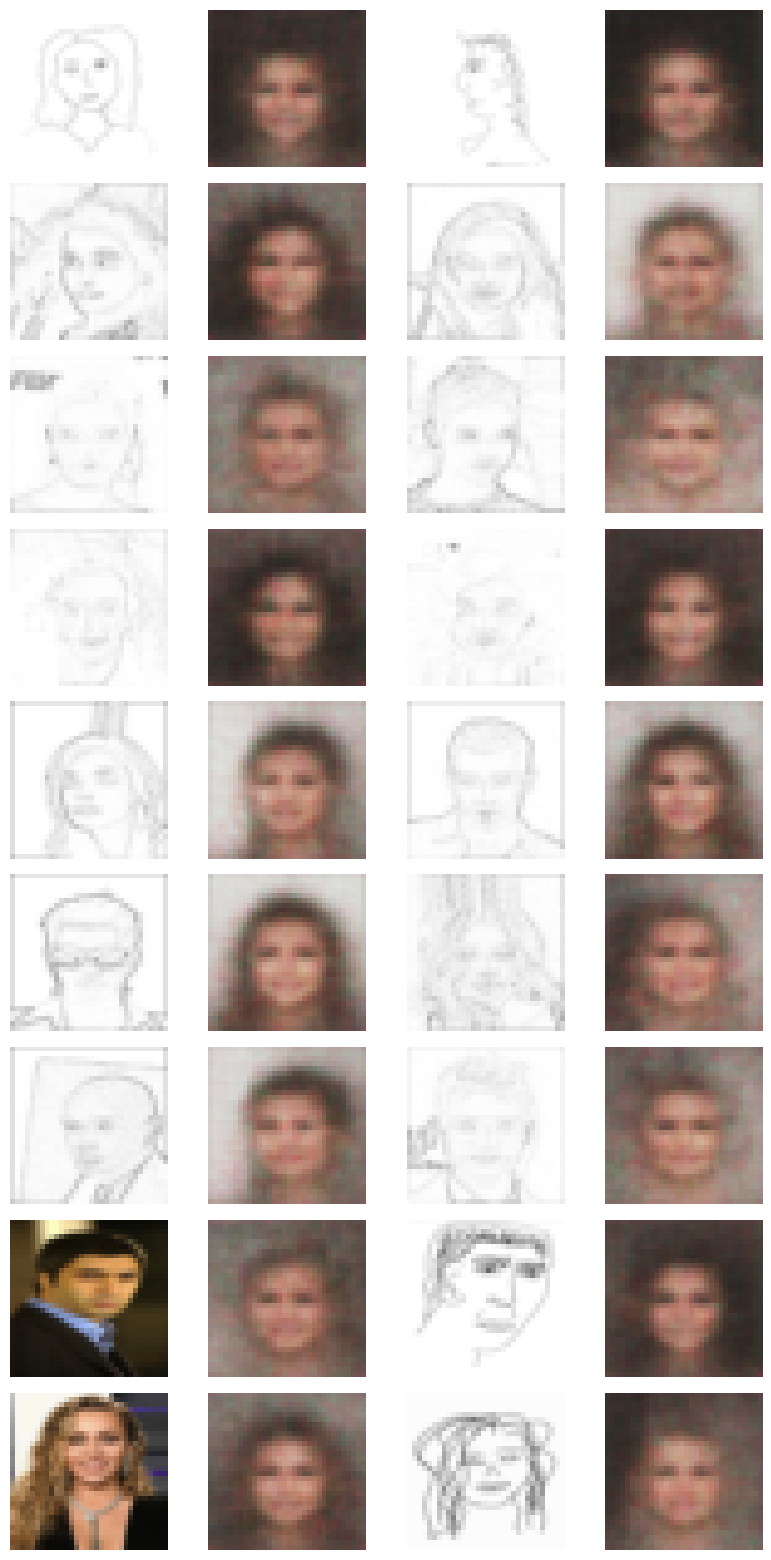

In [10]:
# Pretrained model

# Set the model to evaluation mode
net.eval()

#sample(net, e, batch_size=2)
#calc_inception_score(net, e)
#calc_autoencoder_frechet_distance(net, e)
#calc_clean_fid(net, e)

# Plot the first batch from the test_loader
plot(net, test_loader, 0)



In [40]:
import imageio
import numpy as np
from PIL import Image

def create_gif_from_data(data, output_file='output.gif', duration=8):
    # Select frames (you can adjust this based on your preference)
    selected_frames = range(data.shape[-1])  # Choose all frames

    images = []
    for frame_idx in selected_frames:
        # Convert frame data to image
        frame_data = data[..., frame_idx].cpu().numpy()  # Convert tensor to numpy array
        frame_data = np.transpose(frame_data.squeeze(), (1, 2, 0))  # Squeeze and transpose dimensions
        frame_data = (frame_data * 255).astype(np.uint8)  # Scale data to [0, 255] and convert to uint8
        image = Image.fromarray(frame_data)  # Create PIL image
        images.append(image)

    # Create GIF
    imageio.mimsave(output_file, images, duration=duration)
    
import cv2
import numpy as np

def create_video_from_data(data, output_file='output.mp4', fps=10):
    # Select frames (you can adjust this based on your preference)
    selected_frames = range(data.shape[-1])  # Choose all frames

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, (data.shape[2], data.shape[1]))

    for frame_idx in selected_frames:
        # Convert frame data to image
        frame_data = data[..., frame_idx].cpu().numpy()  # Extract frame data
        frame_data = np.transpose(frame_data.squeeze(), (1, 2, 0))  # Squeeze and transpose dimensions
        frame_data = (frame_data * 255).astype(np.uint8)  # Scale data to [0, 255] and convert to uint8
        frame_data_bgr = cv2.cvtColor(frame_data, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV uses BGR format)

        # Write frame to video
        video_writer.write(frame_data_bgr)

    # Release the VideoWriter object
    video_writer.release()


for batch_idx, (real_img, targets) in enumerate(test_loader.dataset):
    #print(batch_idx)
    real_img = real_img.to(init_device, non_blocking=True)
    targets = targets.to(init_device, non_blocking=True)
    # direct spike input
    spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, 8) # (N,C,H,W,T)
    data = net.simulate(spike_input).detach().cpu() # sampled_z(N,num_classes,T)
    data = (data+0.3)*1.5
    create_gif_from_data(data, output_file=f'output_{batch_idx}.gif', duration=100)
    create_video_from_data(data, output_file=f'output_{batch_idx}.mp4', fps=2)


    

In [ ]:
        torch.save(net.state_dict(), f'checkpoint/{args.name}/best.pth')

In [ ]:
train_loader.dataset.targets

In [ ]:

def train_ae(network, trainloader, opti, epoch):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']
    
    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()

    mean_latent_x = 0

    network = network.train()
    
    for batch_idx, (real_img, targets) in enumerate(trainloader):  
        opti.zero_grad()
        real_img = real_img.to(init_device, non_blocking=True)
        targets = targets.to(init_device, non_blocking=True)

        if glv.network_config['spiking']:
            # direct spike input
            spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
            x_recon, latent_x = network(spike_input, scheduled=network_config['scheduled']) # sampled_z(B,C,1,1,T)
        else:
            # direct input
            x_recon, latent_x = network(real_img)
        
        if network_config['loss_func'] == 'mse':
            losses = network.loss_function_mse(targets, x_recon)
        elif network_config['loss_func'] == 'l1':
            losses = network.loss_function_l1(targets, x_recon)
        elif network_config['loss_func'] == 'ssim':
            losses = network.loss_function_ssim(targets, x_recon)
        elif network_config['loss_func'] == 'lpips':
            losses = network.loss_function_lpips(targets, x_recon)
        else:
            raise ValueError('unrecognized loss function: use mse or l1')
        
        losses['loss'].backward()
        
        opti.step()

        loss_meter.update(losses['loss'].detach().cpu().item())
        recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
        dist_meter.update(losses['Distance_Loss'].detach().cpu().item())
        
        mean_latent_x = (latent_x.mean(0).detach().cpu() + batch_idx * mean_latent_x) / (batch_idx+1) # (C,T)

        print(f'Train[{epoch}/{max_epoch}] [{batch_idx}/{len(trainloader)}] Loss: {loss_meter.avg}, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

        if batch_idx == len(trainloader)-1:
            os.makedirs(f'checkpoint/{args.name}/imgs/train/', exist_ok=True)
            torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/train/epoch{epoch}_input.png')
            torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/train/epoch{epoch}_recons.png')
            writer.add_images('Train/input_img', (real_img+1)/2, epoch)
            writer.add_images('Train/recons_img', (x_recon+1)/2, epoch)

    logging.info(f"Train [{epoch}] Loss: {loss_meter.avg} ReconsLoss: {recons_meter.avg} DISTANCE: {dist_meter.avg}")
    writer.add_scalar('Train/loss', loss_meter.avg, epoch)
    writer.add_scalar('Train/recons_loss', recons_meter.avg, epoch)
    writer.add_scalar('Train/distance', dist_meter.avg, epoch)    

    if glv.network_config['spiking']:
        writer.add_image('Train/mean_latent_x', mean_latent_x.unsqueeze(0), epoch)

    return loss_meter.avg

def test_ae(network, testloader, epoch):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']

    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()
    
    mean_latent_x = 0

    count_mul_add, hook_handles = add_hook(net)

    network = network.eval()
    with torch.no_grad():
        for batch_idx, (real_img, targets) in enumerate(testloader):   
            real_img = real_img.to(init_device, non_blocking=True)
            targets = targets.to(init_device, non_blocking=True)
            
            if glv.network_config['spiking']:
                # direct spike input
                spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
                x_recon, latent_x = network(spike_input, scheduled=network_config['scheduled']) # sampled_z(B,C,1,1,T)
            else:
                # direct input
                x_recon, latent_x = network(real_img)

            if network_config['loss_func'] == 'mse':
                losses = network.loss_function_mse(targets, x_recon)
            elif network_config['loss_func'] == 'l1':
                losses = network.loss_function_l1(targets, x_recon)
            elif network_config['loss_func'] == 'ssim':
                losses = network.loss_function_ssim(targets, x_recon)
            elif network_config['loss_func'] == 'lpips':
                losses = network.loss_function_lpips(targets, x_recon)
            else:
                raise ValueError('unrecognized loss function: use mse or l1')

            mean_latent_x = (latent_x.mean(0).detach().cpu() + batch_idx * mean_latent_x) / (batch_idx+1) # (C,T)
            
            loss_meter.update(losses['loss'].detach().cpu().item())
            recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
            dist_meter.update(losses['Distance_Loss'].detach().cpu().item())

            print(f'Test[{epoch}/{max_epoch}] [{batch_idx}/{len(testloader)}] Loss: {loss_meter.avg}, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

            if batch_idx == len(testloader)-1:
                os.makedirs(f'checkpoint/{args.name}/imgs/test/', exist_ok=True)
                torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/test/epoch{epoch}_input.png')
                torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/test/epoch{epoch}_recons.png')
                writer.add_images('Test/input_img', (real_img+1)/2, epoch)
                writer.add_images('Test/recons_img', (x_recon+1)/2, epoch)
                

    logging.info(f"Test [{epoch}] Loss: {loss_meter.avg} ReconsLoss: {recons_meter.avg} DISTANCE: {dist_meter.avg}")
    writer.add_scalar('Test/loss', loss_meter.avg, epoch)
    writer.add_scalar('Test/recons_loss', recons_meter.avg, epoch)
    writer.add_scalar('Test/distance', dist_meter.avg, epoch)
    
    if glv.network_config['spiking']:
        writer.add_scalar('Test/mul', count_mul_add.mul_sum.item() / len(testloader), epoch)
        writer.add_scalar('Test/add', count_mul_add.add_sum.item() / len(testloader), epoch)
        writer.add_image('Test/mean_latent_x', mean_latent_x.unsqueeze(0), epoch)
    else: 
        writer.add_scalar('Test/mul', count_mul_add.mul_sum / len(testloader), epoch)
        writer.add_scalar('Test/add', count_mul_add.add_sum / len(testloader), epoch)
        writer.add_image('Test/mean_latent_x', mean_latent_x.unsqueeze(0).repeat(1,1,glv.network_config['n_steps']), epoch)
    
    for handle in hook_handles:
        handle.remove()

    return loss_meter.avg


In [ ]:

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
